In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import imageio


2024-02-29 10:56:53.054765: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 10:56:53.196114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 10:56:53.196176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 10:56:53.219764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 10:56:53.270383: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 10:56:53.271002: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist

# FOR DATASET LOCAL

In [4]:
samples_dir = 'samples_png'
image_files = os.listdir(samples_dir)
images = []
labels = []
# Define a dictionary to map symbol names to integers
symbol_dict = {'dot': 0, 'circle': 1, 'ex': 2, 'plus': 3, 'blank': 4}

for image_file in image_files:
    symbol_name = image_file.split('_')[0]  # Extract the symbol name from the filename
    img = Image.open(os.path.join(samples_dir, image_file)).convert('L')
    img = np.array(img)
    img = img / 255.0  # Trim to 7x7 centered and normalize pixel values
    images.append(img)
    label = symbol_dict[symbol_name]  # Map the symbol name to an integer
    labels.append(label)

images = np.array(images).reshape((len(images), 15, 15, 1))  # Reshape the images to add a channel dimension
labels = to_categorical(labels, num_classes=5)  # One-hot encode the labels

# Create an image data generator object
datagen = ImageDataGenerator(
    fill_mode='constant',
    cval=1.0,  # Value used for fill_mode = "constant"
    width_shift_range=4,  # Shift the image left or right by 7 pixels
    height_shift_range=4  # Shift the image up or down by 7 pixels
)

# Fit the data generator to your data
datagen.fit(images)

# Use the data generator to create augmented images
augmented_images, augmented_labels = datagen.flow(images, labels, batch_size=len(images), shuffle=False).next()

# Save the augmented images to a directory
save_dir = 'augmented_images'
os.makedirs(save_dir, exist_ok=True)

for i, (img, label) in enumerate(zip(augmented_images, augmented_labels)):
    # Reshape the image back to 2D and convert to 8-bit unsigned integer format before saving
    img_2d = (img.reshape((15, 15)) * 255).astype(np.uint8)
    # Get the symbol name from the label
    symbol_name = list(symbol_dict.keys())[list(symbol_dict.values()).index(np.argmax(label))]
    # Save the image with the symbol name first
    imageio.imsave(os.path.join(save_dir, f'{symbol_name}_augmented_image_{i}.png'), img_2d)

In [5]:
samples_dir = ['samples_png', 'augmented_images']
images = []
labels = []
# Define a dictionary to map symbol names to integers
symbol_dict = {'dot': 0, 'circle': 1, 'ex': 2, 'plus': 3, 'blank': 4}

for dir in samples_dir:
    image_files = os.listdir(dir)
    for image_file in image_files:
        symbol_name = image_file.split('_')[0]  # Extract the symbol name from the filename
        img = Image.open(os.path.join(dir, image_file)).convert('L')
        img = np.array(img)
        img = img[4:11, 4:11] / 255.0  # Normalize pixel values
        images.append(img)
        label = symbol_dict[symbol_name]  # Map the symbol name to an integer
        labels.append(label)

images = np.array(images)
labels = to_categorical(labels, num_classes=5)  # One-hot encode the labels
print(images.shape) 
print(labels.shape)

(407, 7, 7)
(407, 5)


In [16]:
# Define the neural network architecture
model = Sequential([
    Flatten(input_shape=(7, 7)),
    Dense(37, activation='sigmoid'),
    Dense(5, activation='sigmoid')
])
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49)                0         
                                                                 
 dense_6 (Dense)             (None, 37)                1850      
                                                                 
 dense_7 (Dense)             (None, 5)                 190       
                                                                 
Total params: 2040 (7.97 KB)
Trainable params: 2040 (7.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Split the images and labels into a training set and a test set
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
model.fit(train_images, train_labels, epochs=400)

Epoch 1/400
11/11 [==============================] - 0s 2ms/step - loss: 1.6783 - accuracy: 0.2154
Epoch 2/400
11/11 [==============================] - 0s 2ms/step - loss: 1.6131 - accuracy: 0.1785
Epoch 3/400
11/11 [==============================] - 0s 1ms/step - loss: 1.5799 - accuracy: 0.1815
Epoch 4/400
11/11 [==============================] - 0s 1ms/step - loss: 1.5422 - accuracy: 0.2862
Epoch 5/400
11/11 [==============================] - 0s 1ms/step - loss: 1.5091 - accuracy: 0.3354
Epoch 6/400
11/11 [==============================] - 0s 2ms/step - loss: 1.4819 - accuracy: 0.4462
Epoch 7/400
11/11 [==============================] - 0s 2ms/step - loss: 1.4530 - accuracy: 0.4492
Epoch 8/400
11/11 [==============================] - 0s 2ms/step - loss: 1.4287 - accuracy: 0.4277
Epoch 9/400
11/11 [==============================] - 0s 2ms/step - loss: 1.4020 - accuracy: 0.4738
Epoch 10/400
11/11 [==============================] - 0s 2ms/step - loss: 1.3814 - accuracy: 0.5323
Epoch 11/

In [171]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

3/3 [==============================] - 0s 3ms/step - loss: 0.3590 - accuracy: 0.8780
Test accuracy: 0.8780487775802612


## INTEGER FORMAT WEIGTHS

In [10]:
# Get the weights of the model
weights = model.get_weights()[0] #solo pesos 1ra capa
bias = model.get_weights()[1] #solo bias 1ra capa
# print(len(weights[48]))
# print(len(bias))

# print(range(len(weights)))

with open('weights_and_bias.txt', 'w') as f:
    f.write("{")
    for j in range(len(weights[0])):
        for i in range(len(weights)):
            f.write(f"{np.round(weights[i][j]*255).astype(int)}, ")
        f.write(f"{np.round(bias[j]*2**13).astype(int)}, ")


# Get the weights of the model
weights = model.get_weights()[2] #solo pesos 1ra capa
bias = model.get_weights()[3] #solo bias 1ra capa
# print(len(weights[36]))
# print(len(bias))
with open('weights_and_bias.txt', 'a') as f:
    for j in range(len(weights[0])-1):
            for i in range(len(weights)):
                f.write(f"{np.round(weights[i][j]*255).astype(int)}, ")
            f.write(f"{np.round(bias[j]*2**13).astype(int)}, ")
    f.write("}")

# print(f"{np.round(weights[0][0]*255)}, {np.round(weights[1][0]*255)}, {np.round(bias[0]*2**13)}")
# print(f"{np.round(weights[0][1]*255)}, {np.round(weights[1][1]*255)}, {np.round(bias[1]*2**13)}")
# print(f"{np.round(weights[0][3]*255)}, {np.round(weights[1][3]*255)}, {np.round(bias[3]*2**13)}")


## FLOAT FORMAT WEIGTHS

In [11]:
# Get the weights of the model
weights = model.get_weights()[0] #solo pesos 1ra capa
bias = model.get_weights()[1] #solo bias 1ra capa

with open('weights_and_bias_fp.txt', 'w') as f:
    f.write("{")
    for j in range(len(weights[0])):
        for i in range(len(weights)):
            f.write(f"{weights[i][j]}, ")
        f.write(f"{bias[j]}, ")

# Get the weights of the model
weights = model.get_weights()[2] #solo pesos 1ra capa
bias = model.get_weights()[3] #solo bias 1ra capa

with open('weights_and_bias_fp.txt', 'a') as f:
    for j in range(len(weights[0])-1):
        for i in range(len(weights)):
            f.write(f"{weights[i][j]}, ")
        f.write(f"{bias[j]}, ")
    f.write("}")

## HEX FORMAT WEIGTHS

In [15]:
# Get the weights of the model
weights = model.get_weights()[0] #solo pesos 1ra capa
bias = model.get_weights()[1] #solo bias 1ra capa

with open('weights_and_bias_hex_fp.txt', 'w') as f:
    f.write("{")
    for j in range(len(weights[0])):
        for i in range(len(weights)):
            f.write(f"32'h{format(np.frombuffer(np.float32(weights[i][j]).tobytes(), 'uint32')[0], '08x')}, ")
        f.write(f"32'h{format(np.frombuffer(np.float32(bias[j]).tobytes(), 'uint32')[0], '08x')}, ")

# Get the weights of the model
weights = model.get_weights()[2] #solo pesos 1ra capa
bias = model.get_weights()[3] #solo bias 1ra capa

with open('weights_and_bias_hex_fp.txt', 'a') as f:
    for j in range(len(weights[0])-1):
        for i in range(len(weights)):
            f.write(f"32'h{format(np.frombuffer(np.float32(weights[i][j]).tobytes(), 'uint32')[0], '08x')}, ")
        f.write(f"32'h{format(np.frombuffer(np.float32(bias[j]).tobytes(), 'uint32')[0], '08x')}, ")
    f.write("}")

## test to see weights

In [194]:
weights = model.get_weights()[2] #solo pesos 1ra capa
bias = model.get_weights()[3] #solo bias 1ra capa
print(np.round(weights[:,3]*255).astype(int))
print(np.round(bias[3]*2**13).astype(int))

[ -99  309   91   90  132  178 -161 -153  -37 -293  161 -191 -246 -126
  228   65  130   15  -93  227   22  -89  -58  -79  282   29 -226 -251
   83   39 -151 -166   59   90  -50   -4 -266]
-929


## REVERSE DATA 

In [16]:
with open('weights_and_bias.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers, reverse the list, and join it back into a string
reversed_data = ['{'+', '.join(line.strip('{}').split(', ')[::-1])+'}' for line in data]

# Join the reversed lines into a single string with newline characters between them
reversed_data = '\n'.join(reversed_data)

# Write the reversed string to the file
with open('weights_and_bias.txt', 'w') as f:
    f.write(reversed_data)

#######################################################
with open('weights_and_bias_hex_fp.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers, reverse the list, and join it back into a string
reversed_data = ['{'+', '.join(line.strip('{}').split(', ')[::-1])+'}' for line in data]

# Join the reversed lines into a single string with newline characters between them
reversed_data = '\n'.join(reversed_data)

# Write the reversed string to the file
with open('weights_and_bias_hex_fp.txt', 'w') as f:
    f.write(reversed_data)


#######################################################
with open('weights_and_bias_fp.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers, reverse the list, and join it back into a string
reversed_data = ['{'+', '.join(line.strip('{}').split(', ')[::-1])+'}' for line in data]

# Join the reversed lines into a single string with newline characters between them
reversed_data = '\n'.join(reversed_data)

# Write the reversed string to the file
with open('weights_and_bias_fp.txt', 'w') as f:
    f.write(reversed_data)

## count the number of elements in the array

In [18]:
with open('weights_and_bias.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers and count the numbers
count = [len(line.strip('{}').split(', ')) for line in data]

print(count)


with open('weights_and_bias_hex_fp.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers and count the numbers
count = [len(line.strip('{}').split(', ')) for line in data]

print(count)



with open('weights_and_bias_fp.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers and count the numbers
count = [len(line.strip('{}').split(', ')) for line in data]
print(count)

[2003]
[2002]
[2003]


## Watch the output varying the image input

In [218]:
# Load and preprocess the blank images
#0: dot, 1: circle, 2: ex, 3: plus, 4: blank
blank_images = []
blank_image_files = [file for file in os.listdir(samples_dir[1]) if 'blank' in file]

for image_file in blank_image_files:
    img = Image.open(os.path.join(samples_dir[1], image_file)).convert('L')
    img = np.array(img)
    img = img[4:11, 4:11] / 255.0  # Trim to 7x7 centered and normalize pixel values
    blank_images.append(img)

blank_images = np.array(blank_images)

# Predict the class of the blank images
blank_predictions = model.predict(blank_images)
print(np.round(blank_predictions[:,:-1]*255).astype(int))
# Print the predictions
for i, prediction in enumerate(blank_predictions):
    print(f'Blank image {i+1}: {np.argmax(prediction)}')

1/1 [==============================] - 0s 31ms/step
[[  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]
 [  0 156  64  68]]
Blank image 1: 4
Blank image 2: 4
Blank image 3: 4
Blank image 4: 4
Blank image 5: 4
Blank image 6: 4
Blank image 7: 4
Blank image 8: 4
Blank image 9: 4
Blank image 10: 4
Blank image 11: 4
Blank image 12: 4
Blank image 13: 4
Blank image 14: 4
Blank image 15: 4
Blank image 16: 4
Blank image 17: 4
Blank image 18: 4
Blank image 19: 4
Blank image 20: 4
Blank image 21: 4
Blank image 22: 4
Blank image 23: 4
Blank image 24: 4
Blank image

# FOR DATASET MNIST TF

## Training the model

In [3]:
# Define the model
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Input layer: Flatten the 28x28 images into a 784 dimensional vector
    Dense(128, activation='sigmoid'),  # Hidden layer 1: 128 neurons with ReLU activation
    Dense(64, activation='sigmoid'),   # Hidden layer 2: 64 neurons with ReLU activation
    Dense(10, activation='softmax') # Output layer: 10 neurons (one for each class 0-9) with softmax activation
])
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
#mnis dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Normalize the images to be values between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [6]:
# Train the model
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4649 - accuracy: 0.8820
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1757 - accuracy: 0.9487
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1199 - accuracy: 0.9644
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0889 - accuracy: 0.9738
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0687 - accuracy: 0.9795


In [7]:
import time

# Start the timer
start_time = time.time()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print('\nTest accuracy:', test_acc)
print('Evaluation time:', elapsed_time, 'seconds')

313/313 - 0s - loss: 0.0847 - accuracy: 0.9740 - 457ms/epoch - 1ms/step

Test accuracy: 0.9739999771118164
Evaluation time: 0.5562856197357178 seconds


## Test on weights

In [ ]:
weights = model.get_weights()[0] #solo pesos 1ra capa
bias = model.get_weights()[1] #solo bias 1ra capa
print(weights.shape)
print(bias.shape)
# wieights[:,0] takes the 1st column
# all weights of the 1st neuron in the 1st layer
# wieights[:,1] will take all the weights of the second neuron in the 1st layer 
print(np.round(weights[:,0]*255).astype(int))
print(np.round(bias[0]*2**13).astype(int))

In [52]:
weights = model.get_weights()[4] #solo pesos 3ra capa
print(len(weights))

64


## Watch output varying the image input

(28, 28, 1)
1/1 [==============================] - 0s 18ms/step


Evaluation time: 0.06249809265136719 seconds
Output of last layer neurons:  [[  0  82   0   0   0 132   0  38   0   0]]
Predicted label:  5
Actual label:  2
(1, 28, 28, 1)


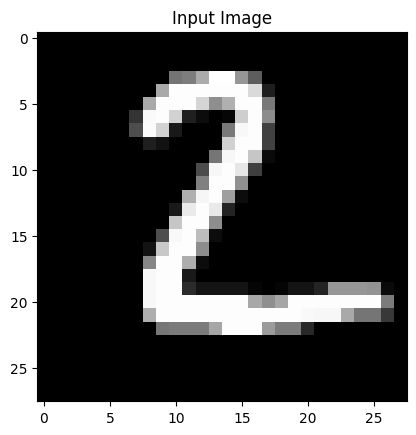

In [53]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
idx = 1
img = test_images[idx]
# img = image.load_img('label_6.png', color_mode="grayscale", target_size=(28, 28))

# Convert the image to a numpy array
#img_array = image.img_to_array(img)
img_array = np.zeros((28,28,1))

# Scale the image pixels by 255
# img_array /= 255.0
# print(img_array)
print(img_array.shape)
# Expand dimensions so the image has the same shape as the training set
img_array = np.expand_dims(img_array, axis=0)

start_time = time.time()

# Get the output of the last layer
model_output = model.predict(img_array)

end_time = time.time()

elapsed_time = end_time - start_time
print('Evaluation time:', elapsed_time, 'seconds')


model_output = (model_output * 255).astype(int)

# Print the output
print("Output of last layer neurons: ", model_output)

# Get the predicted label
predicted_label = np.argmax(model_output)

# Print the predicted label
print("Predicted label: ", predicted_label)
print("Actual label: ", test_labels[idx])

print(img_array.shape)
# Display the input image
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.show()

## INTEGER FORMAT WEIGTHS

In [53]:
# Get the weights of the model
weights = model.get_weights()[0] #solo pesos 1ra capa
bias = model.get_weights()[1] #solo bias 1ra capa

with open('mnist_weights_and_bias.txt', 'w') as f:
    f.write("{")
    for j in range(len(weights[0])): #j from 0 to 128
        #take one column
        for i in range(len(weights)): #i from 0 to 784
            # iterates trought the rows
            f.write(f"{np.round(weights[i][j]*255).astype(int)}, ")
        f.write(f"{np.round(bias[j]*2**13).astype(int)}, ")


# Get the weights of the model
weights = model.get_weights()[2] #solo pesos 2da capa
bias = model.get_weights()[3] #solo bias 2da capa
# print(len(weights[36]))
# print(len(bias))
with open('mnist_weights_and_bias.txt', 'a') as f:
    for j in range(len(weights[0])): #j from 0 to 64
        for i in range(len(weights)): #i from 0 to 128
            f.write(f"{np.round(weights[i][j]*255).astype(int)}, ")
        f.write(f"{np.round(bias[j]*2**13).astype(int)}, ")
    
# Get the weights of the model
weights = model.get_weights()[4] #solo pesos 3ra capa
bias = model.get_weights()[5] #solo bias 3ra capa
# print(len(weights[36]))
# print(len(bias))
with open('mnist_weights_and_bias.txt', 'a') as f:
    for j in range(len(weights[0])): #j from 0 to 10
        for i in range(len(weights)): #i from 0 to 64
            f.write(f"{np.round(weights[i][j]*255).astype(int)}, ")
        f.write(f"{np.round(bias[j]*2**13).astype(int)}, ") 
    f.write("}")



## REVERSE DATA

In [54]:
with open('mnist_weights_and_bias.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers, reverse the list, and join it back into a string
reversed_data = ['{'+', '.join(line.strip('{}').split(', ')[::-1])+'}' for line in data]

# Join the reversed lines into a single string with newline characters between them
reversed_data = '\n'.join(reversed_data)

# Write the reversed string to the file
with open('mnist_weights_and_bias.txt', 'w') as f:
    f.write(reversed_data)

## Count number of elements

In [57]:
with open('mnist_weights_and_bias.txt', 'r') as f:
    data = f.read().split('\n')

# Split each line into a list of numbers and count the numbers
count = [len(line.strip('{}').split(', ')) for line in data]

print(f"total number of parameters on the network: 109386")
print(f"# of parameters exported to file: {count}")

total number of parameters on the network: 109386
# of parameters exported to file: [109386]
